This is a learning project that aims to build an elementary evolutionary neural network to play a simple game of survival. The main idea behind this work is to create a trainable neural network without backpropagation while relying only on random mutations.

IMPORTANT: Python version >= 3.11 is required.

# Game description

The game consists of an environment in the form of a wraparound square field and two types of cells: agents and food. The objective is simple: an agent must collect as many food cells as it can within the given time. 

Each agent is a single linear layer of neurons with an input size relative to the environment size, an output size of 4 and softmax activation.
```python
class Agent:
    def __init__(self, field_size: int=20, primarch: bool=False) -> None:
        if primarch:
            self.weights = np.random.randn(field_size ** 2, 4)
            self.biases = np.zeros(4)
        self.score = 0
        self.field_size = field_size
```

Given the field state as an input, this layer constructs a probability vector that describes the agent's desired direction of the next move. The vector is decoded by argmax into a scalar (0: left, 1: right, 2: down, 3: up). 

```python
class Agent:
        ...
        def forward(self, board: np.ndarray) -> int:
                value = np.matmul(board.flatten().T, self.weights) + self.biases
                softmax = np.exp(value) / (np.exp(value).sum() + 1e-6)
                return np.argmax(softmax)
```

Within one round the agent makes a move after seeing the board, then receives a score increment if successfull at obtaining the food, which is immediately replaced (meaning that multiple points can be acquired in one round). This loop continues until the time runs out:
```python
while time_remaining > 0:
    if not food_exists:
        #place a food on a random cell other than the agent's position

    board = #initialize the board
    action = agent.forward(board)

    match action:
        case 0:
            ...

    if agent.pos == food_pos:
        food_exists = False
        agent.score += 1

    time_remaining -= 1
```

If the agent fails to acquire any food at all, I thought it would be useful to still give it some score (it will accelerate initial evolution). That score is proportional to the shortest distance remaining to the food in the last round (in steps) and the ```fail_reward``` parameter.

A generation is a process of survival and selection, where the ones performing better get to reproduce. The following events occur in each generation:

1. All agents play for a set number of rounds and receive their total score:
```python 
    
    for agent in self.agents:
        scores.append(np.mean([play_round(agent, ...
```
2. The ones that will reproduce are determined based on performance:
```python

    reproducing_agents = sorted(zip(self.agents, scores), key=lambda x: x[1], 
                                reverse=True)[:n_reproducing]
```
3. Children are created via the specified reproduction method, then they receive a random mutaion and are added to the next generation of agents:
```python

    self.agents = []
    parent = iter(reproducing_agents)
    match reproduction_type:
        case 'sexual':
            for parent1, parent2 in zip(parent, parent):
                for _ in range(int(2 / reproducing_percentage)):
                    child = parent1[0].reproduce(parent2[0], 
                                                type='sexual')
                    child.mutate(mutation_rate=mutation_rate)
                    self.agents.append(child)
        case 'asexual':
            for parent0 in parent:
                for _ in range(int(1 / reproducing_percentage)):
                    child = parent0[0].reproduce(type='asexual')                        
                    child.mutate(mutation_rate=mutation_rate)
                    self.agents.append(child)
```

The mutation operation is just an addition of Gaussian noise to the 'genome':
```python
def mutate(self, mutation_rate: float=0.01) -> None:
    self.weights += np.random.randn(*self.weights.shape) * mutation_rate
    self.biases += np.random.randn(*self.biases.shape) * mutation_rate
```

In [4]:
evo.train(n_generations=n_generations,
          rounds_per_agent=rounds_per_agent,
          mutation_type=mutation_type,
          initial_mutation_rate=initial_mutation_rate,
          pairing_type=pairing_type,
          reproducing_percentage=reproducing_percentage,
          reproduction_type=reproduction_type,
          output_path=output_path)

Generation 1000/20000	 high score: 9.6
Generation 2000/20000	 high score: 10.8
Generation 3000/20000	 high score: 10.8
Generation 4000/20000	 high score: 11.1
Generation 5000/20000	 high score: 11.6
Generation 6000/20000	 high score: 12.1
Generation 7000/20000	 high score: 12.1
Generation 8000/20000	 high score: 12.5
Generation 9000/20000	 high score: 12.8
Generation 10000/20000	 high score: 12.9
Generation 11000/20000	 high score: 12.9
Generation 12000/20000	 high score: 12.9
Generation 13000/20000	 high score: 13.35
Generation 14000/20000	 high score: 13.35
Generation 15000/20000	 high score: 13.35
Generation 16000/20000	 high score: 13.35
Generation 17000/20000	 high score: 13.35
Generation 18000/20000	 high score: 13.35
Generation 19000/20000	 high score: 13.35
Generation 20000/20000	 high score: 14.1


In [1]:
import pickle
import matplotlib.pyplot as plt
from evo.network import Evo

In [2]:
n_agents = 100
field_size = 10
evo = Evo(n_agents, field_size)

In [3]:
n_generations = 20000
rounds_per_agent = 10
mutation_type = 'constant' #'adaptive' or 'constant'
initial_mutation_rate = 0.1
pairing_type = 'best' # 'best' or 'random'
reproducing_percentage = 0.2 #it is recommended n_agents * this % 2 == 0
reproduction_type = 'sexual' #'sexual' or 'asexual'
output_path = 'data/results.pkl'

In [4]:
with open(output_path, 'rb') as file:
    results = pickle.load(file)

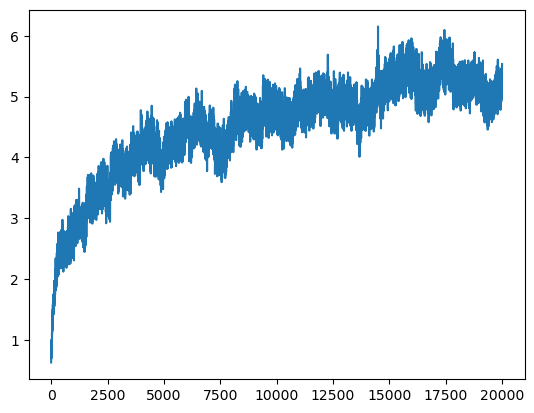

In [5]:
plt.plot(results['mean scores'])

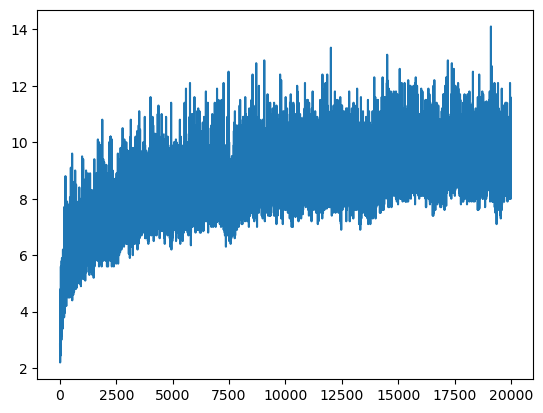

In [6]:
plt.plot(results['high scores'])

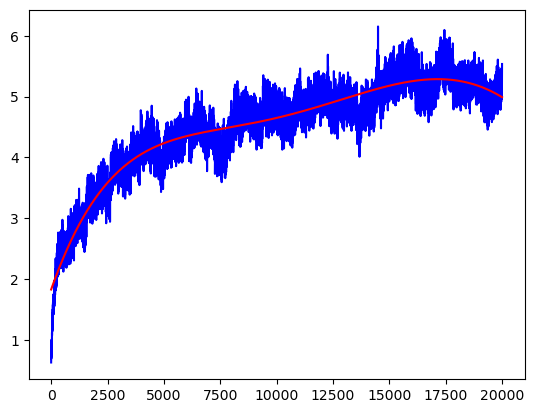

In [7]:
import numpy as np
x = range(len(results['mean scores']))
y = results['mean scores']
p = np.polynomial.polynomial.Polynomial.fit(x, y, deg=5)

fig = plt.figure()

plt.plot(results['mean scores'], c='blue')
plt.plot(p(x), c='red')


In [8]:
agent = sorted(zip(
    results['best agents'],
    results['high scores']
), key=lambda x: -x[1])[0][0]

In [9]:
from evo.play import vizualize_round

In [13]:
agent.score = 0.0
vizualize_round(agent, path='data/agents/agent1', time_limit=50)

2.0

Text(0.5, 1.0, 'Time remaining: 60 \n score: 0')

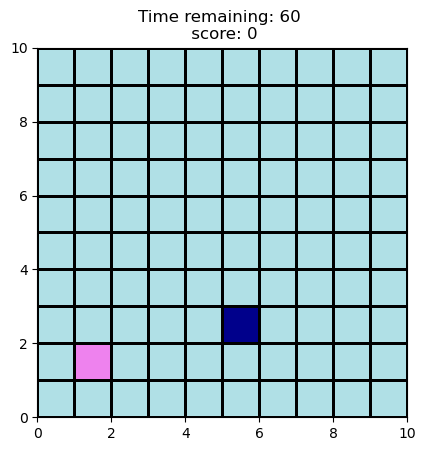

In [39]:
from matplotlib import colors
cmap = colors.ListedColormap(['darkblue', 'powderblue', 'violet'])

board = np.zeros((field_size, field_size))
board[(1, 1)] = 1
board[(2, 5)] = -1
plt.pcolormesh(board, edgecolors='black', cmap=cmap)
ax=plt.gca()
ax.set_aspect('equal')

plt.title('Time remaining: 60 \n score: 0')
#plt.axis('off')

In [32]:
from PIL import Image
import os

images_path = sorted(os.listdir('data/agents'), key=lambda x: int(x.split()[1].split('.')[0]))
images = [Image.open('data/agents/'+file) for file in images_path]

In [39]:
images[0].save('animation.gif', 
               save_all=True,
               append_images=images[1:],
               duration=250,
               loop=1)

<img src='animation.gif'>